In [1]:
import os
import sys
from pathlib import Path

curr_dir = Path(os.path.split(os.getcwd())[0])

api_dir = str(curr_dir)
if api_dir not in sys.path:
    sys.path.insert(0, api_dir)
    
from datetime import datetime
import json
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

from src.handler import XBox2ContextDataCreator
from src.model.classifier import Classifier
from src.utils.dataset_creator import load_dataset
from src.datasets.ECG200 import ECG200
from src.model.explainer import explain_samples
from src.model.sample_explainers.gradient_shap import ShapGradientExplainer

not_swan_default_modules = ["shap","coloredlogs"]
for name in not_swan_default_modules:
    if not name in sys.modules:
        !pip install --user name

2021-10-12 14:24:07.667024: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-10-12 14:24:07.667041: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Load dataset
dataset from https://www.timeseriesclassification.com/description.php?Dataset=ECG200

In [2]:
train, valid, test = load_dataset(creator=ECG200(), data_path=Path(api_dir) / "src/datasets/ECG200")

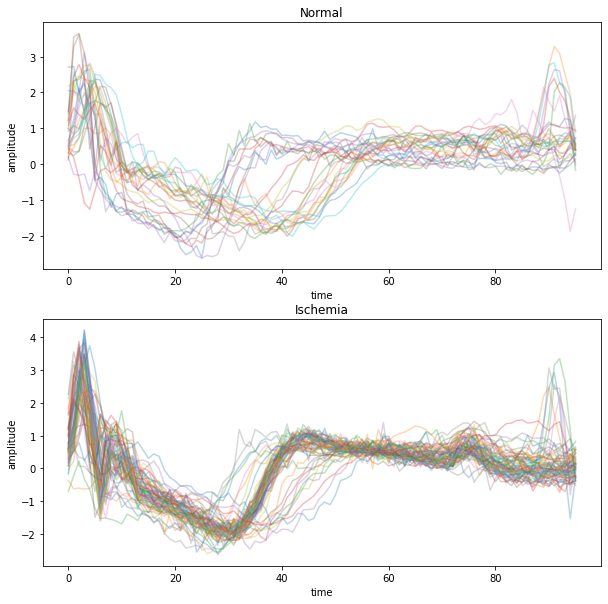

In [6]:
fig, ax = plt.subplots(2,1, figsize=(10,10))
ax[0].plot(train.X[train.y.argmax(axis=1) == 0][:,:,0].T, alpha=0.3)
ax[0].set_title("Normal")
ax[0].set_xlabel("time")
ax[0].set_ylabel("amplitude")
ax[1].plot(train.X[train.y.argmax(axis=1) == 1][:,:,0].T, alpha=0.3)
ax[1].set_title("Ischemia")
ax[1].set_xlabel("time")
ax[1].set_ylabel("amplitude")
plt.show()

# Classify heartbeats

In [7]:
# Load hyperparameters
hp_file = open(Path(api_dir) / "src/model/default_hyperparameters.json")
hp_dict = json.load(hp_file)
hp_dict

{'classifier_name': 'fcn',
 'num_classes': 2,
 'monitor': 'loss',
 'loss': 'categorical_crossentropy',
 'optimizer': 'adam',
 'epochs': 200,
 'batch_size': 60,
 'learning_rate': 0.001,
 'reduce_lr_factor': 0.5,
 'reduce_lr_patience': 50,
 'min_lr': 0.0001}

In [8]:
# define and fit classifier
clf = Classifier(input_shape=train.X.shape, output_directory=Path(api_dir) / "src/output", **hp_dict)
clf.fit_classifier(train, valid)

2021-10-12 14:35:05.818413: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-10-12 14:35:05.818433: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-10-12 14:35:05.818461: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (hsb-cern): /proc/driver/nvidia/version does not exist
2021-10-12 14:35:05.818611: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-10-12 14:35:07.256325: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optim

Epoch 1/200
2/2 [==============================] - 8s 602ms/step - loss: 0.6663 - tp: 64.0000 - fp: 26.0000 - tn: 64.0000 - fn: 26.0000 - accuracy: 0.7111 - precision: 0.7111 - recall: 0.7111 - auc: 0.7546 - prc: 0.7141 - val_loss: 0.7977 - val_tp: 5.0000 - val_fp: 5.0000 - val_tn: 5.0000 - val_fn: 5.0000 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 0.5000 - val_auc: 0.5200 - val_prc: 0.5006
Epoch 2/200
2/2 [==============================] - 0s 39ms/step - loss: 0.6059 - tp: 64.0000 - fp: 26.0000 - tn: 64.0000 - fn: 26.0000 - accuracy: 0.7111 - precision: 0.7111 - recall: 0.7111 - auc: 0.7063 - prc: 0.6482 - val_loss: 0.9025 - val_tp: 5.0000 - val_fp: 5.0000 - val_tn: 5.0000 - val_fn: 5.0000 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 0.5000 - val_auc: 0.5300 - val_prc: 0.5069
Epoch 3/200
2/2 [==============================] - 0s 58ms/step - loss: 0.6134 - tp: 64.0000 - fp: 26.0000 - tn: 64.0000 - fn: 26.0000 - accuracy: 0.7111 - precision: 0.7

In [9]:
# make predictions
y_pred = clf.model.predict(x=test.X)

In [10]:
# eval classifier
results = clf.model.evaluate(x=test.X, y=test.y, return_dict=True)
pd.DataFrame.from_dict(results, orient='index').T

4/4 [==============================] - 0s 4ms/step - loss: 0.5853 - tp: 83.0000 - fp: 17.0000 - tn: 83.0000 - fn: 17.0000 - accuracy: 0.8300 - precision: 0.8300 - recall: 0.8300 - auc: 0.9193 - prc: 0.9139


,loss,tp,fp,tn,fn,accuracy,precision,recall,auc,prc
0,0.585297,83.0,17.0,83.0,17.0,0.83,0.83,0.83,0.9193,0.913938


# Explain predictions

In [11]:
is_correct_pred = (y_pred.argmax(axis=1) == test.y.argmax(axis=1))
ex_pred = explain_samples(explainer=ShapGradientExplainer(),
                                 model=clf.model,
                                 X_reference=train.X,
                                 X_to_explain=test.X[is_correct_pred, :, :])

`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


In [12]:
def plot_importance(X_to_explain, y_pred, explanation):
    cmap = mpl.colors.LinearSegmentedColormap.from_list('shap', [mpl.cm.cool(0), (1, 1, 1, 1), mpl.cm.cool(256)],N=256)
    
    fig, ax = plt.subplots(figsize=(7,5))  
    ax.plot(X_to_explain[(y_pred.argmax(axis=1) == 0), :, :].mean(axis=0), linewidth=3, c="b")
    ax.plot(X_to_explain[(y_pred.argmax(axis=1) == 1), :, :].mean(axis=0), linewidth=3, c="r")
    
    extent = [0, len(X_to_explain[0]), ax.get_ylim()[0], ax.get_ylim()[1]]
    im1 = ax.imshow(explanation[0].mean(axis=0).T, cmap=cmap, aspect="auto", alpha=0.8, extent=extent)  
    cbar1 = fig.colorbar(im1, ax=ax)
    cbar1.set_label("SHAP values (relative)")

    ax.set_xlabel("samples")
    ax.set_title("Explanations of Correct Predictions")
    ax.legend(["mean normal","mean ischemia"])

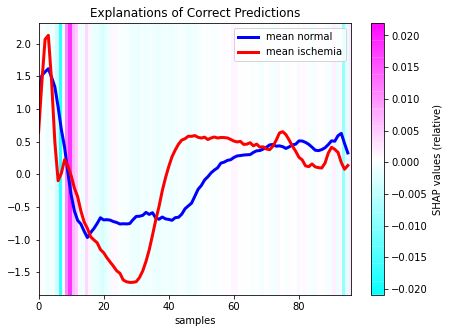

In [13]:
plot_importance(X_to_explain = test.X, y_pred = y_pred, explanation = ex_pred)